# Spot-checking inicial: Árvore de Decisão

As árvores de decisão são conhecidas por possuírem um baixo viés, ao mesmo tempo em que apresentam alta variância.
Isto é, o método é capaz de modelar fronteiras de decisão bastante complexas, o que, por um lado, é positivo, mas torna o algoritmo bastante suscetível a ruído ou a padrões nos dados de treino que não generalizam para instâncias de teste.
Por isso, técnicas de poda são fundamentais para o uso efetivo do modelo em dados novos.

Nessa atividade, iremos analisar como a estrutura e as predições da árvore de decisão são afetadas por pequenas variações no conjunto de treino. Além disso, veremos duas técnicas de poda que podem ser usadas para controlar a complexidade do modelo.

## Carregamento dos Dados

### Obtenção e análise dos dados
O código abaixo carrega o dataset utilizando as funções do scikit-learn e mostra algumas informações básicas sobre os dados

In [ ]:
import pandas as pd

In [ ]:
df_sinan_processed = pd.read_csv("../data/processed/teste.csv")

In [6]:
# Matriz de atributos
X = df_sinan_processed.drop("severity", axis=1)

# Vetor alvo
y = df_sinan_processed["severity"]

In [7]:
feature_names = X.columns.tolist()
target_names = ["low_risk", "alarm", "severe", "lethal"]

In [8]:
# Contar exemplos por classe
from collections import Counter 

class_counts = Counter(y)
for cls, count in class_counts.items():
    print(f"Número de exemplos na classe '{cls}': {count}")

Número de exemplos na classe 'low_risk': 420845
Número de exemplos na classe 'lethal': 276
Número de exemplos na classe 'alarm': 4510
Número de exemplos na classe 'severe': 231


## Variância nas Árvores de Decisão


### Analisando a Estrutura das Árvores de Decisão


Como estudado em aula, a árvore de decisão é conhecida por ser um classificador com alta variância. Isso possui consequências na estrutura das árvores treinadas.

O código abaixo treina várias árvores de decisão com diferentes conjuntos de treino obtidos através do método holdout.


In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split  # função do scikit-learn que implementa um holdout


def get_root_node(dt, feature_names):
    feature_idx = dt.tree_.feature[0]
    return feature_names[feature_idx]


n_repeats = 5
root_nodes = []

# variando o seed do holdout, geramos conjuntos de treino e teste um pouco diferentes a cada iteração
for split_random_state in range(0, n_repeats):
  # Holdout com 20% de dados de teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  # Treinamento da árvore usando os dados de treino
  dt = DecisionTreeClassifier(random_state=0)
  dt.fit(X_train, y_train)

  # Obtemos o atributo usado na raiz e o salvamos na lista
  root_node = get_root_node(dt, feature_names)
  root_nodes.append(root_node)

root_nodes

['apresenta_leucopenia',
 'apresenta_leucopenia',
 'apresenta_leucopenia',
 'apresenta_leucopenia',
 'apresenta_leucopenia']

### Analisando a Acurácia das Árvores de Decisão

A propriedade de variância também implica em efeitos na variabilidade da performance dos modelos.
Podemos usar a acurácia como medida de performance, o que pode ser feito também através do scikit-learn. Posteriormente estudaremos outras métricas de desempenho que são mais indicadas para problemas em que o número de instâncias por classe é desbalanceado, como é o caso deste conjunto de dados.

In [14]:
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia nos dados de teste: %.3f" % accuracy)


Acurácia nos dados de teste: 0.974


O código abaixo executa repetidas vezes o treinamento das árvores de decisão, da mesma forma que no item *Analisando a Estrutura das Árvores de Decisão*.

**Atenção: Não mude os valores que estão sendo passados para os parâmetros random_state para garantir a reprodutibilidade do código**.


In [16]:
import numpy as np

accuracies = []

# variando o seed do holdout, geramos conjuntos de treino e teste um pouco diferentes a cada iteração
for split_random_state in range(0, n_repeats):
  # Holdout com 20% de dados de teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=split_random_state)

  # Nova instância da árvore de decisão
  dt = DecisionTreeClassifier(random_state=0)

  # Treinamento da árvore usando os dados de treino
  dt.fit(X_train, y_train)

  # Calcule a acurácia nos dados de teste, montando uma lista com os valores calculados
  y_pred = dt.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  accuracies.append(accuracy)

# Calcule a média, desvio padrão, máximo e mínimo das acurácias (pode usar numpy)
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)
max_accuracy = np.max(accuracies)
min_accuracy = np.min(accuracies)

print(f"Acurácia média: {mean_accuracy:.3f}")
print(f"Desvio padrão: {std_accuracy:.3f}")
print(f"Acurácia máxima: {max_accuracy:.3f}")
print(f"Acurácia mínima: {min_accuracy:.3f}")


Acurácia média: 0.973
Desvio padrão: 0.001
Acurácia máxima: 0.973
Acurácia mínima: 0.972


## Observando o Efeito da Poda

As árvores de decisão treinadas nos itens anteriores não possuíam nenhuma forma de poda. No entanto, é possível utilizar técnicas de poda através do scikit-learn. Como consequência, elas podem ter uma complexidade além do que é necessário na modelagem do problema.



### Exemplo de Pré-poda: profundidade máxima da árvore
Podemos especificar a profundidade máxima da árvore utilizando o hiperparâmetro max_depth. Veja como exemplo o código abaixo.

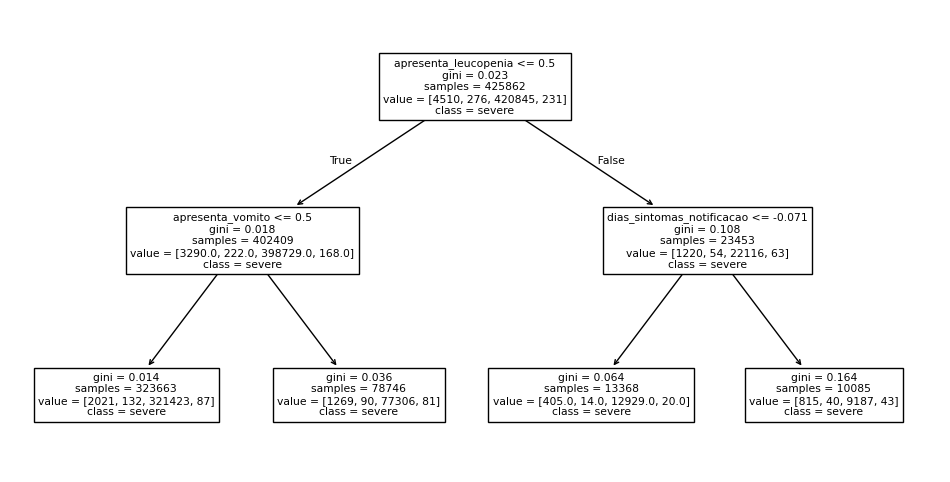

In [36]:
import matplotlib.pyplot as plt

dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X, y)

from sklearn.tree import plot_tree
plt.figure(figsize=(12,6))
_ = plot_tree(dt, feature_names=feature_names, class_names=target_names)

O código abaixo gera árvores de decisão com diferentes profundidades máximas e as avalia em termos de acurácia.

Observe que todas as árvores são treinadas e avaliadas com os mesmos conjuntos de treino, validação e teste, visto que especificamos o parâmetro $random\_state = 42$.

Com base nesse código, e possíveis modificações que você faça a ele, responda à Questão  4 do questionário.

**Não mude o valor que está sendo passado em random_state**.


In [29]:
## Definindo as proporções de treino, validação e teste.
train_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

## Fazendo a primeira divisão, para separar um conjunto de teste dos demais.
## Assuma X_temp e y_temp para os dados de treinamento+validação e X_test e y_test para os de teste
## Dica: configure o random_state para facilitar reprodutibilidade dos experimentos

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_ratio,random_state=42,stratify=y)

## Fazendo a segunda divisão, para gerar o conjunto de treino e validação a partir
## do conjunto de 'treinamento' da divisão anterior
## Assuma X_train e y_train para os dados de treinamento e X_valid e y_valid para os de teste
## Dica: configure o random_state para facilitar reprodutibilidade dos experimentos

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=validation_ratio/(train_ratio+test_ratio),random_state=42,stratify=y_temp)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(298102, 43)
(63880, 43)
(63880, 43)


In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Distribuição original do treino:", Counter(y_train))

# Crie uma instância do SMOTE
smote = SMOTE(random_state=42)

# Aplique o SMOTE APENAS nos dados de treino
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Distribuição do treino após SMOTE:", Counter(y_train_resampled))

Distribuição original do treino: Counter({'low_risk': 294590, 'alarm': 3157, 'lethal': 194, 'severe': 161})
Distribuição do treino após SMOTE: Counter({'low_risk': 294590, 'lethal': 294590, 'alarm': 294590, 'severe': 294590})


In [39]:
max_depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None]  # None faz com que essa poda não seja aplicada
accuracies_valid = []
accuracies_train = []
for depth in max_depths:
  dt = DecisionTreeClassifier(max_depth=depth, random_state=0)
  dt.fit(X_train_resampled, y_train_resampled) # Usando os dados balanceados com SMOTE

  y_pred = dt.predict(X_valid)
  acc = accuracy_score(y_valid, y_pred)
  accuracies_valid.append(acc)
  accuracies_train.append(dt.score(X_train, y_train)) ##para analisar overfitting

In [40]:
accuracies_valid

[0.3874608641202254,
 0.39514715090795244,
 0.570742016280526,
 0.5426424546023795,
 0.5680964308077645,
 0.5681120851596744,
 0.6330463368816531,
 0.61203819661866,
 0.6776299311208516,
 0.659439574201628,
 0.6974796493425173,
 0.6851127113337507,
 0.9569661865998748]

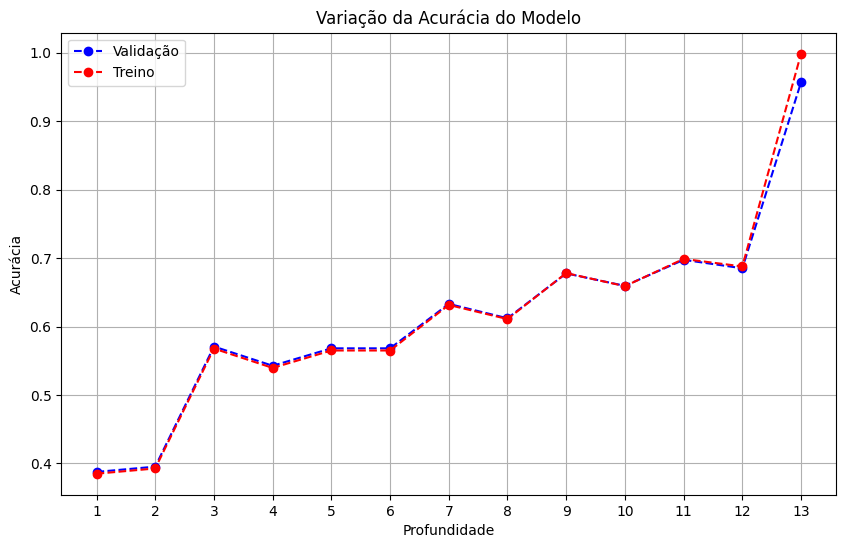

In [41]:
# Plotar a variação das acurácias
plt.figure(figsize=(10,6))
plt.plot(range(1, len(max_depths)+1),  accuracies_valid, marker='o', linestyle='--', color='b', label='Validação')
plt.plot(range(1, len(max_depths)+1), accuracies_train, marker='o', linestyle='--', color='r', label='Treino')
plt.title('Variação da Acurácia do Modelo')
plt.xlabel('Profundidade')
plt.ylabel('Acurácia')
plt.xticks(range(1, len(max_depths)+1))
plt.legend()
plt.grid(True)
plt.show()

Para avaliarmos o desempenho do modelo otimizado em novos dados, devemos repetir o treinamento selecionando o melhor valor de hiperparâmetro(s) com base no gráfico anterior, e fazer a avaliação nos dados de teste.
Para melhorar a capacidade de estimar o desempenho do modelo, podemos treinar com os dados de treinamento e validação, tendo em vista que ambos são independentes do conjunto de teste (dados nunca vistos).


In [ ]:
best_max_depth = 13 ## preencha aqui com o melhor valor do hiperparâmetros, conforme análise anterior

In [42]:
# concatena dados de treino e validação, para treinar modelo a ser avaliado com dados de teste
X_train2 = np.concatenate((X_train, X_valid), axis=0)
y_train2 = np.concatenate((y_train, y_valid), axis=0)

In [47]:
smote_final = SMOTE(random_state=42)
X_train_final, y_train_final = smote_final.fit_resample(X_train2, y_train2)

In [48]:
print("Distribuição após SMOTE final:", Counter(y_train_final))

Distribuição após SMOTE final: Counter({'low_risk': 357718, 'lethal': 357718, 'alarm': 357718, 'severe': 357718})


In [49]:
# treina e avalia a árvore de decisão com valor otimizado de max_depth
dt = DecisionTreeClassifier(max_depth=best_max_depth, random_state=0)
dt.fit(X_train_final, y_train_final)

y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

/home/max/ML/TrabalhoPraticoML/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


0.8051189730745147

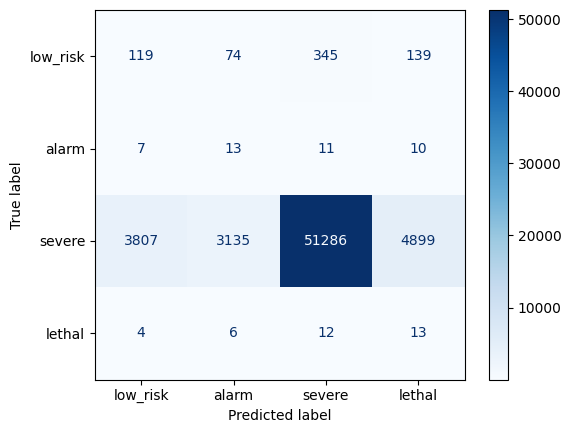

In [50]:
# Plota a matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_names, cmap=plt.cm.Blues)